In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import requests 
import json
import networkx as nx

In [2]:
def signature_extractor(file):
    
    # Preprocessing data before 
            #calculating up/down regulated genes
        
    stat = pd.read_table(file, sep=" ")
    stat = stat.apply(pd.to_numeric)
    
    up_genes = []
    down_genes = []
    names = stat.columns
    stat = stat.sort_values(by=["logFC", "PValue"], ascending=[False, True])
    
    # calculating up/down regulated genes
    
    up_genes = list(stat[:3000].index)
    down_genes = list(stat[-3000:].index)
    return up_genes, down_genes

In [84]:
class protein_network:
    
    """
    class protein_network could be used to represent PPI (protein-protein interaction) networks both in graph and adjacency list forms
    
    Attributes
    ----------
    up_genes: a list of overexpressed genes
    down_genes: a list of underexpressed genes
    interactions_up: a list of interactions for upregulated genes
    interactions_down: a list of interactions for downregulated genes
    adjac_list_up: a list of tuples where each tuple represents interaction of every single upregulated gene
    adjac_list_down: a list of tuples where each tuple represents interaction of every single downregulated gene


    Methods
    -------
    data_preprocessing(mode, species=9606)
        preprocesses a list of genes by checking their presence in STRING database;
        two modes are available: 
            - "up_genes" for upregulated genes
            - "down_genes" for downregulated genes
            
    API_request(mode, species=9606)
        make a request to STRING DB to get interaction network
    
    creating_adj_list(mode, score)
        creates an ajacency list out list with interactions; possibly could filter only protein metting score requirements
    
    creating_network(mode)
        creates a graph out of the adjacency matrix made below
    
    writing_adj_lists(mode)
        stores adjacency list into a file called mode.adjlist
        
    visualising_graph(mode)
        visualises PPI network
        
    """
        
    def __init__(self, up_genes, down_genes):
        
        self.up_genes = up_genes
        self.down_genes = down_genes
        self.interactions_up = []
        self.interactions_down = []
        self.adjac_list_up = []
        self.adjac_list_down = []
        
    def data_preprocessing(self, mode, species=9606):
        
        string_api_url = "https://string-db.org/api"
        output_format = "tsv-no-header"
        method = "network"

        ##
        ## Construct URL
        ##

        request_url = "/".join([string_api_url, output_format, method])

        ##
        ## Set parameters
        ##
        
        my_genes = {
                'up_genes': self.up_genes,
                'down_genes': self.down_genes
                }
        genes_in_string = {
                'up_genes': [],
                'down_genes': []
                }
        
        
        for gene in tqdm.tqdm(my_genes[mode]):
            
            params = {

                "identifiers" : "%0d".join(gene), # your protein
                "species" : species, # species NCBI identifier 
                "caller_identity" : "www.awesome_app.org" # your app name

            }

            ##
            ## Call STRING
            ##

            response = requests.post(request_url, data=params)
            
            flag = True
            for line in response.text.strip().split("\n"):
                l = line.strip().split("\t")
                try:
                    p1, p2 = l[2], l[3]
                    
                except IndexError:
                    flag = False
                    continue
                    
            if flag == True:
                genes_in_string[mode].append(gene)
     
    
        if mode == 'up_genes':    
            self.up_genes = genes_in_string['up_genes']
        else:
            self.down_genes = genes_in_string['down_genes']            
        
        print(len(genes_in_string[mode]))
        
        
    def API_request(self, mode, species = 9606):
        
        ##
        ## Preprocessing genes
        ##
        
        self.data_preprocessing(mode)
        
        string_api_url = "https://string-db.org/api"
        output_format = "tsv-no-header"
        method = "network"
        
        request_url = "/".join([string_api_url, output_format, method])

        my_genes = {
                'up_genes': self.up_genes[:2000],
                'down_genes': self.down_genes[:2000]
                }
        
        ##
        ## Set parameters
        ##

        params = {

            "identifiers" : "%0d".join(my_genes[mode]), # your protein
            "species" : species, # species NCBI identifier 
            "caller_identity" : "www.awesome_app.org" # your app name

        }

        ##
        ## Call STRING
        ##

        response = requests.post(request_url, data=params)
        
        interactions = []
        
        for line in response.text.strip().split("\n"):
            l = line.strip().split("\t")
            try:
                p1, p2 = l[2], l[3]
            ## filter the interaction according to experimental score
                experimental_score = float(l[10])
                interactions.append((p1, p2, experimental_score))
            except IndexError:
                print("Getting an error")
                print(response.text)
                
        if mode == 'up_genes':    
            self.interactions_up = interactions
        else:
            self.interactions_down = interactions
            
        return interactions
    
    def creating_adj_list(self, mode, score = 0.0):
        
        adja_list = []
        genes = {
                'up_genes': self.up_genes[:2000],
                'down_genes': self.down_genes[:2000]
                }
        if mode == "up_genes":
            interactions = self.interactions_up[:2000]
        else:
            interactions = self.interactions_down[:2000]
        
        for ind_i, line in enumerate(genes[mode]):
            adja_list.append([])
            for  ind_j, col in enumerate(genes[mode]):
                for ind_k, inter in enumerate(interactions):
                    if line == inter[0] and col == inter[1] and float(inter[2]) >= score:
                        if adja_list[ind_i] != [] and adja_list[ind_i][-1] != inter[1]:
                            adja_list[ind_i].append(inter[1])
                        elif adja_list[ind_i] == [] and inter[1] != "" and adja_list[ind_i-1] != inter[1]:
                            adja_list[ind_i].append(inter[1])
            
            
            adja_list[ind_i] = tuple([genes[mode][ind_i]] + adja_list[ind_i])
                            
        if mode == 'up_genes':    
            self.adjac_list_up = adja_list
        else:
            self.adjac_list_down = adja_list
            
        return adja_list
    
    def creating_network(self, mode):
        
        if mode == "up_genes":
            adj_list = [" ".join(line) for line in self.adjac_list_up]
        else:
            adj_list = [" ".join(line) for line in self.adjac_list_down]
        adj_list_nx = nx.parse_adjlist(adj_list)
        
        return adj_list_nx
        
    def writing_adj_lists(self, mode):
        
        graph = self.creating_adj_list(mode)
        
        if mode == "up_genes":
            nx.write_adjlist(graph, "up_genes.adjlist")
        if mode == "down_genes":
            nx.write_adjlist(graph, "down_genes.adjlist")
            
    def visualising_graph(self, mode):
        
        options = {
            'node_size': 10,
            'width': 2
        }
        graph = self.creating_network(mode)
        
        return nx.draw(graph, **options)

In [85]:
stat = pd.read_table("~/Downloads/DE_heart_fb_deseq2_edger.txt", sep=" ")

In [86]:
up_genes, down_genes = signature_extractor("~/Downloads/DE_heart_fb_deseq2_edger.txt")

In [87]:
print(len(up_genes), len(down_genes))

3000 3000


In [88]:
up_genes = [str(gene) for gene in up_genes]
down_genes = [str(gene) for gene in down_genes]

In [89]:
%%time
up = protein_network(up_genes, down_genes)  
up.API_request(mode="up_genes")
up.creating_adj_list(mode="up_genes", score=0.1)

100%|██████████| 3000/3000 [38:42<00:00,  1.29it/s] 


917
CPU times: user 2min 5s, sys: 4.8 s, total: 2min 9s
Wall time: 39min 52s


[('C14ORF180',),
 ('PPP1R3A', 'PPP1R2'),
 ('GIMAP7',),
 ('FCGR2A', 'FCGR2B'),
 ('LINC01330',),
 ('FCGR3A', 'FCGR3B', 'FCGR1A'),
 ('C19ORF48',),
 ('RP11-1221G12.2',),
 ('FOLR2',),
 ('C10ORF71',),
 ('MYOZ2',),
 ('CCL21', 'CXCL13'),
 ('C11ORF21',),
 ('MYZAP',),
 ('S100A12',),
 ('C10ORF128',),
 ('KLHL31',),
 ('RP11-415I12.2',),
 ('SPINK7',),
 ('FGL1',),
 ('RP11-766F14.2',),
 ('RP11-403I13.4',),
 ('RP11-701H24.9',),
 ('FP325317.1',),
 ('AL365273.1',),
 ('FITM1',),
 ('FMO2',),
 ('RP11-574E24.3',),
 ('RP11-1081M5.3',),
 ('DEFA1',),
 ('PPP1R2P1',),
 ('FCGR3B',),
 ('FCER1A',),
 ('C8ORF22',),
 ('FAM25A',),
 ('BP-2171C21.2',),
 ('RP11-382B18.5',),
 ('CFAP61',),
 ('RP11-506K19.1',),
 ('FCGR2C',),
 ('IGKV1D-39',),
 ('KBTBD13',),
 ('METTL12',),
 ('UGT2B10',),
 ('BTF3L4P4',),
 ('AC004381.8',),
 ('RBFOX1',),
 ('RP11-236F9.2',),
 ('RP11-588F10.1',),
 ('AC073850.6',),
 ('IGLV2-14',),
 ('FCN3',),
 ('FABP3',),
 ('SLAMF1',),
 ('MTND1P21',),
 ('AC104389.1',),
 ('EIF4A2', 'RPL21', 'NOP56', 'RPL13A', 'EIF4E3'

In [97]:
print(len(up.adjac_list_up))

917


In [91]:
graph_up = up.creating_network("up_genes")
print("number nodes:", len(list(graph_up.nodes)))
print("number edges:", len(list(graph_up.edges)))

number nodes: 917
number edges: 48


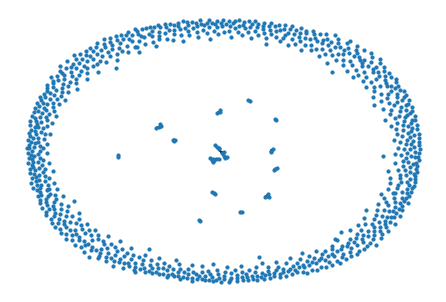

In [92]:
pictures_up = up.visualising_graph("up_genes")
pictures_up

In [93]:
%%time
down = protein_network(up_genes, down_genes)
down.API_request(mode="down_genes")
down.creating_adj_list(mode="down_genes")

100%|██████████| 3000/3000 [38:22<00:00,  1.30it/s] 


965
CPU times: user 3min 8s, sys: 4.75 s, total: 3min 13s
Wall time: 40min 36s


[('ZNF503', 'FOXP1'),
 ('RP11-428L21.2',),
 ('RP11-543P15.1',),
 ('RP11-350G24.2',),
 ('ZNF20',),
 ('FKBP14', 'FKBP10'),
 ('FAT1',),
 ('FMO11P',),
 ('RP11-339B21.8',),
 ('TNFRSF12A', 'TNFSF11', 'FGF17'),
 ('CYP24A1', 'FGF23', 'CYP4F22', 'CYP26A1'),
 ('RP11-795H16.2',),
 ('CTD-2267D19.4',),
 ('ST13P11',),
 ('RP11-701I24.1',),
 ('AC012362.3',),
 ('AC105342.1',),
 ('EEF1B2P2',),
 ('RP11-313J2.1',),
 ('HIST1H3H',
  'H2BFS',
  'H2AFX',
  'HIST1H3B',
  'HIST1H2AH',
  'HIST1H2AB',
  'HIST1H2BJ',
  'HIST1H2BM',
  'HIST1H2BI',
  'HIST1H3C',
  'HIST1H2AL',
  'HIST1H3F',
  'HIST1H3I',
  'HIST1H2BL',
  'HIST1H2BH',
  'HIST1H2BO',
  'HIST1H3G',
  'UHRF1'),
 ('FXYD5',),
 ('RP3-403A15.5',),
 ('C11ORF24',),
 ('RP4-663N10.2',),
 ('RP11-434D2.9',),
 ('RP1-85D24.1',),
 ('NOP56P2',),
 ('FGF23',
  'FGFR2',
  'FAM20C',
  'FSTL1',
  'SLC20A1',
  'FBN1',
  'IGFBP3',
  'TNFSF11',
  'FGF2',
  'FN1',
  'FGF17',
  'TNFRSF11B',
  'FGF19'),
 ('OR2L13',),
 ('H2BFS',),
 ('RP11-525G12.1',),
 ('PDLIM7',),
 ('CHPF2', 'X

In [94]:
down.down_genes

['ZNF503',
 'RP11-428L21.2',
 'RP11-543P15.1',
 'RP11-350G24.2',
 'ZNF20',
 'FKBP14',
 'FAT1',
 'FMO11P',
 'RP11-339B21.8',
 'TNFRSF12A',
 'CYP24A1',
 'RP11-795H16.2',
 'CTD-2267D19.4',
 'ST13P11',
 'RP11-701I24.1',
 'AC012362.3',
 'AC105342.1',
 'EEF1B2P2',
 'RP11-313J2.1',
 'HIST1H3H',
 'FXYD5',
 'RP3-403A15.5',
 'C11ORF24',
 'RP4-663N10.2',
 'RP11-434D2.9',
 'RP1-85D24.1',
 'NOP56P2',
 'FGF23',
 'OR2L13',
 'H2BFS',
 'RP11-525G12.1',
 'PDLIM7',
 'CHPF2',
 'MRPS21P1',
 'WFDC2',
 'CTA-268H5.9',
 'ABCA13',
 'HIST1H2AD',
 'RPL22L1',
 'NTF3',
 'RAB31',
 'NR2F1',
 'RP6-218J18.2',
 'RP11-318A15.7',
 'RPL12P10',
 'C1ORF106',
 'ST13P2',
 'FGFR2',
 'PMFBP1',
 'RP3-486D24.1',
 'AC109815.2',
 'SHISA7',
 'EIF4BP3',
 'SERPINB12',
 'HMGB3P13',
 'SLC16A2',
 'RP11-475C16.1',
 'RP1-258N20.3',
 'SLC25A1',
 'TCF3',
 'C11ORF70',
 'CHAF1B',
 'C4ORF51',
 'SLC2A14',
 'RP11-587D21.1',
 'FKBP11',
 'RTN3P1',
 'AC008565.1',
 'TERF1',
 'RP11-1012A1.4',
 'PF4V1',
 'RP11-79P5.3',
 'FNDC11',
 'RP5-1046G13.2',
 'YBX

In [95]:
graph_down = down.creating_network("down_genes")
print("number nodes:", len(list(graph_down.nodes)))
print("number edges:", len(list(graph_down.edges)))

number nodes: 965
number edges: 976


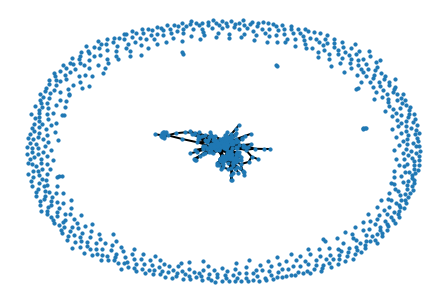

In [96]:
pictures_down = down.visualising_graph("down_genes")
pictures_down